## Data Import

In [1]:
## Importo Librerías
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [3]:
df = pd.read_csv('course_lead_scoring.csv')

In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
df_0 = df

In [6]:
df.shape

(1462, 9)

## Data preparation

In [7]:
## Check nulos
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [9]:
categorical  = ['lead_source', 'industry','employment_status', 'location']

In [10]:
numerical  = ['number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score']

In [11]:
df[categorical] = df[categorical].fillna('NA')

In [12]:
## Check nulos
df_0.isnull().sum()

lead_source                   0
industry                      0
number_of_courses_viewed      0
annual_income               181
employment_status             0
location                      0
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [13]:
##Para ver los valores que asume una dimensión
df["lead_source"].unique()

array(['paid_ads', 'social_media', 'events', 'referral', 'organic_search',
       'NA'], dtype=object)

In [14]:
df[numerical] = df[numerical].fillna(0.0)

In [15]:
## Check nulos
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Question 1

In [16]:
df.groupby('industry').size()

industry
NA               134
education        187
finance          200
healthcare       187
manufacturing    174
other            198
retail           203
technology       179
dtype: int64

R1: retail 

### Question 2

In [17]:
import seaborn as sns ## para graficos de estadistica

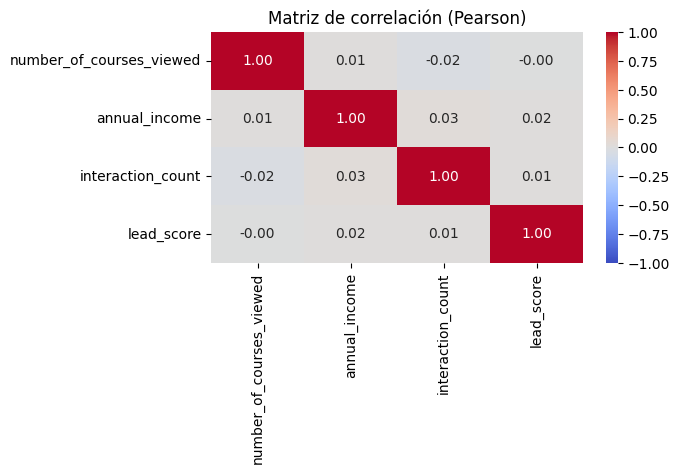

In [18]:
## Matriz de correlación

# Selecciono solo columnas numéricas y elijo método
corr = df[numerical].corr(method="pearson")

# grafico
plt.figure(figsize=(6, 3))
sns.heatmap(
    corr,
    annot=True,          # escribe el número dentro de cada celda
    fmt=".2f",           # 2 decimales
    cmap="coolwarm",     # azul-negativo / rojo-positivo
    vmin=-1, vmax=1      # escala completa
)
plt.title("Matriz de correlación (Pearson)")
plt.show()

R2: annual_income and interaction_count

## Question 3

In [19]:
## Divido el dataset 
from sklearn.model_selection import train_test_split

In [20]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [22]:
len(df_train), len(df_test), len(df_val)

(876, 293, 293)

In [23]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [24]:
y_train=df_train.converted.values
y_val=df_val.converted.values
y_test=df_test.converted.values

In [25]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

##### Feature importance: Mutual information

In [26]:
from sklearn.metrics import mutual_info_score

In [27]:
for c in categorical:
    coef = mutual_info_score (df_full_train.converted, df_full_train[c])
    print(c, round(coef,2))

lead_source 0.03
industry 0.01
employment_status 0.01
location 0.0


R3: lead_source

## Question 4

In [28]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score

In [29]:
## One Hot Encoding
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)

dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [30]:
X_train.shape

(876, 31)

In [31]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [32]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [33]:
y_pred = model.predict(X_val)

In [34]:
original_score = accuracy_score(y_val, y_pred)
round(original_score,2)
## Este valor me da igual que si tomo la probabilidad y el 0.5 como decisión.

0.7

R4: 0.74 (closest)

## Question 5

In [35]:
features = df_train.columns.to_list()
features

['lead_source',
 'industry',
 'number_of_courses_viewed',
 'annual_income',
 'employment_status',
 'location',
 'interaction_count',
 'lead_score']

In [36]:
scores_5 = pd.DataFrame(columns=['eliminated_feature', 'accuracy', 'difference'])
for feature in features:
    subset = features.copy()
    subset.remove(feature)
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[subset].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0, random_state=42)
    model.fit(X_train, y_train)
    
    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    
    scores_5.loc[len(scores_5)] = [feature, score, original_score - score]

In [37]:
scores_5

,eliminated_feature,accuracy,difference
0,lead_source,0.703072,-0.003413
1,industry,0.699659,0.000000
2,number_of_courses_viewed,0.556314,0.143345
3,annual_income,0.853242,-0.153584
4,employment_status,0.696246,0.003413
5,location,0.709898,-0.010239
6,interaction_count,0.556314,0.143345
7,lead_score,0.706485,-0.006826


In [38]:
scores_5[scores_5.index == scores_5.difference.abs().idxmin()]

,eliminated_feature,accuracy,difference
1,industry,0.699659,0.0


R5: industry

## Question 6

In [39]:
## One Hot Encoding
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)

dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [40]:
## Defino modelo con regularización:
scores_6 = {}
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', max_iter=1000, C=C, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    score = accuracy_score(y_val, y_pred)
    scores_6[C] = round(score, 3)
    print(f'C = {C}:\t Accuracy = {score}')

C = 0.01:	 Accuracy = 0.6996587030716723
C = 0.1:	 Accuracy = 0.6996587030716723
C = 1:	 Accuracy = 0.6996587030716723
C = 10:	 Accuracy = 0.6996587030716723
C = 100:	 Accuracy = 0.6996587030716723


In [41]:
print(f'The smallest `C` is {max(scores_6, key=scores_6.get)}.')

The smallest `C` is 0.01.


R6: 0.01